# Import Dependencies

In [236]:
import pandas as pd
import numpy as np

# Data Preperation

### Load Dataset

In [237]:
# Import dataset
dataset = pd.read_csv("train.csv")

### Preprocess the dataset

In [238]:
from sklearn.model_selection import train_test_split

# divide preliminary dataset set into features and labels
X = dataset.drop(columns=["label"]) # features
y = dataset['label'] # labels

# split the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y) # 80 to 20% randomly

### Train a Decision Tree Classifier to obtain feature importances

In [239]:
from sklearn.tree import DecisionTreeClassifier

clf_DT=DecisionTreeClassifier() # creating Decision Tree classifier
clf_DT.fit(X_train,y_train) # fitting training data into Decision Tree Model

DecisionTreeClassifier()

### Identify columns with zero feature importances

In [240]:
# find feature importances
importances = clf_DT.feature_importances_ 

# identify columns where feature importances are zero
zeroCols = np.where(importances==0)

# modify the zeroCols list to match with columns in csv
zeroCols = ["pixel"+str(i) for i in zeroCols[0]]

### drop non-important columns from the dataset 


In [241]:
# remake the dataset by dropping non-important columns
newData = dataset.drop(columns=zeroCols)

# divide new dataset set into features and labels
X =newData.drop(columns=["label"]) # features
y= newData["label"] # labels

print("Number of dropped columns are: %d" % (dataset.shape[1]-newData.shape[1]))

Number of dropped columns are: 320


### Re-split the reduced-column dataset

In [242]:
# split the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y) # 80 to 20% randomly

### Prepare Feature Importance Graph

<function matplotlib.pyplot.show(close=None, block=None)>

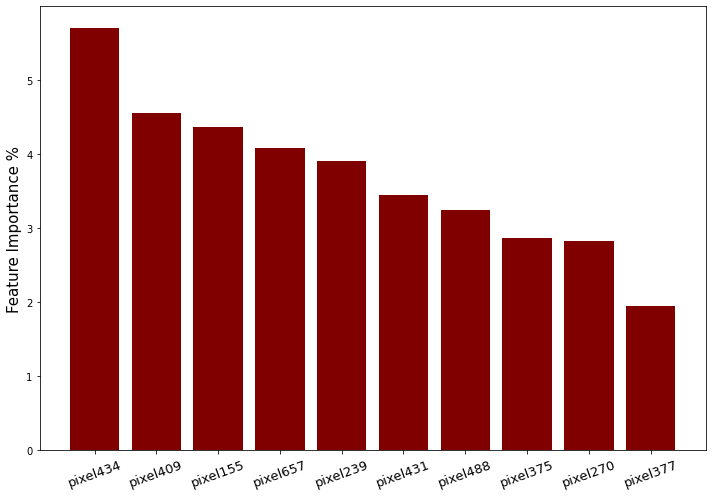

In [271]:
from matplotlib import pyplot as plt

# Create Importances Graph
indices = np.argsort(importances)[::-1]

plt.ylabel('Feature Importance %',fontsize=15)
plt.bar(["pixel"+str(i) for i in indices[:10]],
        importances[indices][:10]*100,
        align='center',color="maroon")
plt.xticks(rotation=20,fontsize=13)
plt.show


### Check Class distribution

In [244]:
# check whether class distribution is inbalanced in order to decide whether to use k-fold or stratified
y_train.value_counts()

1    3747
7    3521
3    3481
9    3350
2    3342
6    3310
0    3305
4    3258
8    3250
5    3036
Name: label, dtype: int64

In [245]:
y_test.value_counts()

1    937
7    880
3    870
9    838
2    835
0    827
6    827
4    814
8    813
5    759
Name: label, dtype: int64

# Modelling

### Function: save_model

In [246]:
from joblib import dump

def save_model(model,model_name):
    filename = str(model_name)+".pkl"
    dump(model,open("./models/"+filename,"wb"))

### Function load_model

In [247]:
from joblib import load

def load_model(model_name):
    filename = str(model_name)+".pkl"
    loaded_model = load(open(filename, 'rb'))
    return loaded_model

In [248]:
from pathlib import Path
from pickle import load
import os
def load_model(model_name):
    filename = str(model_name)+".pkl"
    current_directory = Path(__file__).parent #Get current directory
    file = open(os.path.join(current_directory, 'models', filename), 'rb') #rb = read bytes because we are reading the file
    return load(file) #We give it the file and it loads in everything from the file. That data is the loaded as the variable loadedData

### k-fold Cross Validation

In [249]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# empty dictionary for saving k-fold cross validation score
kfold_scores = {'SVM':[],'DecTree':[],'RandomForest':[]}  

# evaluate a given model using cross-validation
def cross_val(model, X, y):
	# define the evaluation procedure
	cv = KFold(n_splits=5)
	
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

	print("%0.3f mean accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
	return scores

### k-fold Cross Validation

In [250]:
from sklearn.model_selection import cross_validate

# empty dictionary for saving k-fold cross validation score
kfold_scores = {'SVM':[],'DecTree':[],'RandomForest':[]}  

# Overloading cross_val method if user wants to save the best scoring
def cross_val(model, X, y, name):
	# evaluate the model and collect the results, (cv=None uses 5-fold cross validation by default)
	scores = cross_validate(model, X, y, cv=None,
                            return_estimator=True,
                            scoring=('accuracy'))
	index = scores['test_score'].argmax()
	best_model = scores["estimator"][index]
	save_model(best_model,name)
	print("%0.3f mean accuracy with a standard deviation of %0.4f" % (scores["test_score"].mean(), scores["test_score"].std()))
	return best_model, scores["test_score"]

### Decision Tree (DT) Model

In [251]:
from sklearn.tree import DecisionTreeClassifier

clf_DT = DecisionTreeClassifier(max_depth=10) # creating DT classifier
model_DT, score = cross_val(clf_DT,X_train,y_train,"DecisionTree") # k-fold cross validation
kfold_scores['DecTree'] = score # note the accuracy score of DT model

0.841 mean accuracy with a standard deviation of 0.0066


### Random Forest (RF) Model

In [252]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(random_state=None) # creating RF classifier
model_RF, score = cross_val(clf_RF,X_train,y_train,"RandomForest") # k-fold cross validation
kfold_scores['RandomForest'] = score # note the accuracy score of RF model

0.962 mean accuracy with a standard deviation of 0.0015


### Support Vector Machine (SVM) Model 

In [253]:
from sklearn import svm

clf_SVM = svm.SVC(decision_function_shape='ovo') # creating SVM classifier
model_SVM, score = cross_val(clf_SVM,X_train,y_train,"SVM") # k-fold cross validation
kfold_scores['SVM'] = score # note the accuracy score of SVM model

0.974 mean accuracy with a standard deviation of 0.0020


In [254]:
pd.DataFrame(kfold_scores)

,SVM,DecTree,RandomForest
0,0.975595,0.842113,0.963393
1,0.972024,0.827679,0.962054
2,0.973958,0.844792,0.962946
3,0.976488,0.843155,0.963542
4,0.971280,0.845833,0.959375


### Plot the k-fold cross validation results for all models

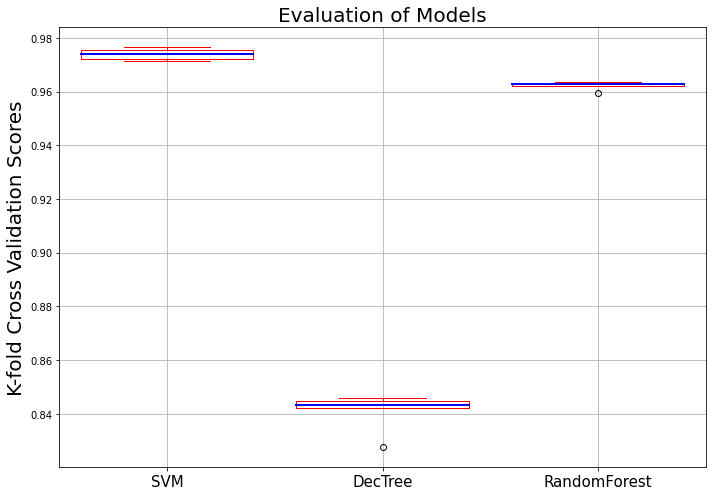

In [255]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))
data =[np.array(val) for  val in kfold_scores.values()]
bp = ax.boxplot(data,widths=[0.8,0.8,0.8])
# change the color of the meanline

for _, line_list in bp.items():
    for line in line_list:
        line.set_color('r')
for meanline in bp['medians']:
    meanline.set_color('blue')
    meanline.set(linewidth=2)
plt.xticks([1, 2, 3], [key for key in kfold_scores.keys()],fontsize=15)
plt.ylabel("K-fold Cross Validation Scores", fontsize=20)
plt.tight_layout()
plt.title("Evaluation of Models",fontsize=20)
plt.grid()
plt.show()

# Prediction

In [256]:
from sklearn.metrics import accuracy_score

test_accuracy={'SVM':[],'DecTree':[],'RandomForest':[]}

### Predict by Decision Tree Model

In [257]:
# make predictions for DT model using test set and note its accuracy
prediction = model_DT.predict(X_test) # making predictions for DT model
test_accuracy['DecTree'] = accuracy_score(y_test,prediction) # note the accuracy of DT model

### Predict by Random Forest Model

In [258]:
# make predictions for RF model using test set and note its accuracy
prediction = model_RF.predict(X_test) # making predictions for RF model
test_accuracy['RandomForest'] = accuracy_score(y_test,prediction) # note the accuracy of RF model

### Predict by SVM Model

In [259]:
# make predictions for SVM model using test set and note its accuracy
prediction = model_SVM.predict(X_test) # making predictions for SVM model
test_accuracy['SVM'] = accuracy_score(y_test,prediction) # note the accuracy of SVM model

In [260]:
test_accuracy

{'SVM': 0.9763095238095238,
 'DecTree': 0.8513095238095238,
 'RandomForest': 0.9647619047619047}

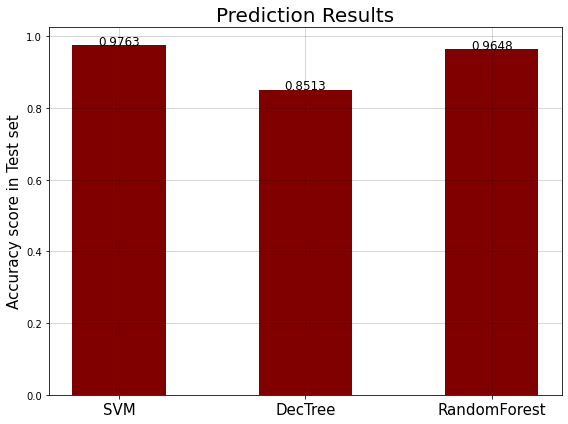

In [286]:
import matplotlib.pyplot as plt

data = [val for val in test_accuracy.values()]
methods = [key for key in test_accuracy.keys()]

def add_text(Xtick):
    for x in Xtick:
        plt.text(x,test_accuracy[x],"%.4f" % test_accuracy[x],fontsize=12,ha="center")
fig = plt.figure(figsize = (8, 6))
plt.bar(methods, data, width=0.5, color="maroon")
add_text(methods)
plt.ylabel("Accuracy score in Test set",fontsize=15)
plt.xticks(fontsize=15)
plt.title("Prediction Results",fontsize=20)
plt.grid(color="black", alpha=0.2)
plt.show()